# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
#importing important libarary
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split

In [2]:
import math
from sklearn.naive_bayes import MultinomialNB

In [3]:
con = sqlite3.connect("database.sqlite")

In [4]:
amzn = pd.read_sql_query('''SELECT * 
                            FROM Reviews 
                            WHERE Score != 3 
                            ORDER BY Time ''', con)

In [5]:
def partition(score):
    if score < 3:
        return 0
    else : 
        return 1
amzn_score = amzn["Score"] 
filter_amzn = amzn_score.map(partition)
amzn['Score'] = filter_amzn

In [6]:
#Deduplication of entries
final= amzn.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [7]:
final['Score'].value_counts()

1    307063
0     57110
Name: Score, dtype: int64

In [8]:
final = final.iloc[0:100000]

In [9]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [10]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [11]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|█████████████████████████████████| 100000/100000 [03:24<00:00, 488.58it/s]


In [12]:
len_of_review = []
for i in range(0, len(preprocessed_reviews)):
    len_of_review.append(len(preprocessed_reviews[i]))
 

In [13]:
#splitting data into train and test
x_train = preprocessed_reviews[slice(0,80000)]
x_cv = preprocessed_reviews[slice(80000, 90000)]
x_test = preprocessed_reviews[slice(90000, 100000)]
y_train = final.iloc[:80000, 6]
y_cv = final.iloc[80000:90000, 6]
y_test = final.iloc[90000:100000, 6]



In [14]:
xtr_len_rvw = np.asarray((len_of_review[slice(0,80000)])).reshape(-1,1)
xcv_len_rvw = np.asarray((len_of_review[slice(80000,90000)])).reshape(-1,1)
xts_len_rvw = np.asarray((len_of_review[slice(90000,100000)])).reshape(-1,1)

In [15]:
# Please write all the code with proper documentation
#defining function for Bag of words
def bow(para, bow_x_cv, bow_x_test):  
    bow_vect = CountVectorizer() #in scikit-learn
    bow_x_train = bow_vect.fit_transform(para)
    bow_x_cv = bow_vect.transform(x_cv)
    bow_x_test = bow_vect.transform(x_test)
    return bow_x_train, bow_x_cv, bow_x_test , bow_vect


In [16]:
bow_x_train, bow_x_cv, bow_x_test , bow_vect = bow(x_train, x_cv, x_test)

In [17]:
auc_cv = []
auc_test = []
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for i in tqdm(alpha):
    
    # instantiate learning model (k = 30)
    bow_clf = MultinomialNB(alpha = i)
    # fitting the model on crossvalidation train
    bow_clf.fit(bow_x_train, y_train)
    
    y_pred_proba = bow_clf.predict_proba(bow_x_cv)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_cv,  y_pred_proba)
    auc_cv.append(np.round(metrics.roc_auc_score(y_cv, y_pred_proba)*100))
    
    y_pred_proba1 = bow_clf.predict_proba(bow_x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba1)
    auc_test.append(np.round(metrics.roc_auc_score(y_test, y_pred_proba1)*100))
    

100%|██████████████████████████████████████████| 10/10 [00:02<00:00,  4.00it/s]


In [18]:
bow_optimal_alpha = alpha[(auc_cv.index(max(auc_cv)))]

In [19]:
#Taking log of alpha value to print easely on graph with correcsponding auc
log_alpha = []
for i in alpha:
    log_alpha.append(math.log10(i))
log_alpha    

[-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]

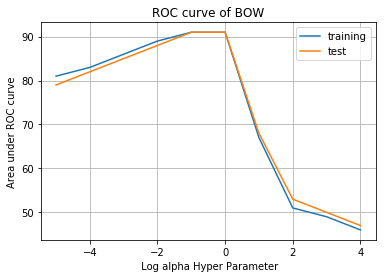

In [20]:
#printing all Auc value of corresponding k on validation and test data
df = pd.DataFrame({
                  'training': auc_cv,
                  'test': auc_test
                  }, index= log_alpha )

lines = df.plot.line()
plt.xlabel(" Log alpha Hyper Parameter")
plt.ylabel("Area under ROC curve")
plt.title("ROC curve of BOW")
plt.grid()
plt.show()

In [21]:
bow_clf = MultinomialNB(alpha = bow_optimal_alpha)
bow_clf.fit(bow_x_train, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

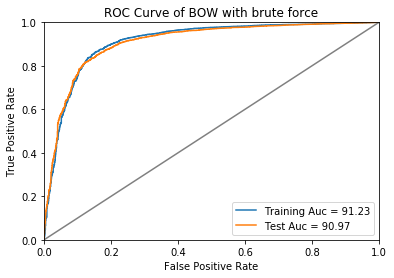

In [22]:
#auc curve of optimal k on validation and test data
y_predk_proba = bow_clf.predict_proba(bow_x_cv)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_cv,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_cv, y_predk_proba)*100, 2)
bow_tr_auc = auc

plt.plot(fpr,tpr,label="Training Auc = "+str(auc))
y_predk_proba = bow_clf.predict_proba(bow_x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_test, y_predk_proba)*100, 2)
bow_ts_auc = auc

plt.plot(fpr,tpr,label="Test Auc = "+str(auc))
plt.legend(loc=4)
plt.plot([x/10 for x in range(0, 11)],[x/10 for x in range(0, 11)], color='grey')
plt.title("ROC Curve of BOW with brute force")
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [23]:
y_pred_test = bow_clf.predict(bow_x_test)

In [24]:
y_pred_cv = bow_clf.predict(bow_x_cv)

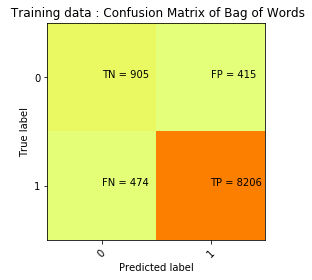

In [25]:
# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_cv,y_pred_cv)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title(' Training data : Confusion Matrix of Bag of Words')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

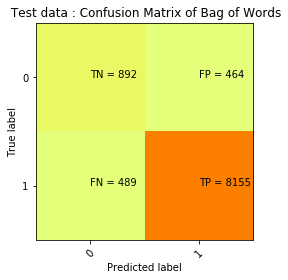

In [26]:
# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_test,y_pred_test)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title(' Test data : Confusion Matrix of Bag of Words')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

In [ ]:
### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [27]:
# Please write all the code with proper documentation

In [28]:
bow_features_prob = bow_clf.feature_log_prob_

In [29]:
len(bow_vect.get_feature_names())

52873

In [30]:
print(max(bow_features_prob[0,:]))
print(max(bow_features_prob[1,:]))

-3.283491443705362
-3.769539615025577


In [31]:
bow_pos_df = pd.DataFrame({'log prob': bow_features_prob[1,:],
                   'word': bow_vect.get_feature_names()[:]
                  })
bow_pos_largest_10= bow_pos_df.nlargest(10, 'log prob')


In [32]:
from prettytable import PrettyTable
    
x = PrettyTable()
print("Top Ten features belonging to class positive or 1 of BOW")
x.field_names = ["Top ten fetures", "Features Log Probability", "Word"]
for i in range(0, 10):
    x.add_row([i+1, bow_pos_largest_10["log prob"].values[i] ,\
               bow_pos_largest_10["word"].values[i]])

print(x)

Top Ten features belonging to class positive or 1 of BOW
+-----------------+--------------------------+---------+
| Top ten fetures | Features Log Probability |   Word  |
+-----------------+--------------------------+---------+
|        1        |    -3.769539615025577    |   not   |
|        2        |    -4.58321474507472     |   like  |
|        3        |    -4.67420236216444     |   good  |
|        4        |    -4.708309351749447    |  great  |
|        5        |   -4.7773753491664745    |   tea   |
|        6        |    -4.916138850361724    |   one   |
|        7        |    -4.951832774046444    |  taste  |
|        8        |    -5.072981421342307    |  flavor |
|        9        |   -5.1001163957680475    | product |
|        10       |   -5.1464248686838765    |   love  |
+-----------------+--------------------------+---------+


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [33]:
# Please write all the code with proper documentation


In [34]:
bow_neg_df = pd.DataFrame({'log prob': bow_features_prob[0,:],
                   'word': bow_vect.get_feature_names()[:]
                  })
bow_neg_largest_10= bow_neg_df.nlargest(10, 'log prob')


In [35]:
from prettytable import PrettyTable
    
x = PrettyTable()
print("Top Ten features belonging to class negative or 0 of BOW")
x.field_names = ["Top ten fetures", "Features Log Probability", "Word"]
for i in range(0, 10):
    x.add_row([i+1, bow_neg_largest_10["log prob"].values[i] , \
                    bow_neg_largest_10["word"].values[i]])

print(x)

Top Ten features belonging to class negative or 0 of BOW
+-----------------+--------------------------+---------+
| Top ten fetures | Features Log Probability |   Word  |
+-----------------+--------------------------+---------+
|        1        |    -3.283491443705362    |   not   |
|        2        |    -4.413734029834188    |   like  |
|        3        |    -4.659594416423131    | product |
|        4        |    -4.661770044813865    |  taste  |
|        5        |    -4.663132220145728    |  would  |
|        6        |    -4.830082218684968    |   one   |
|        7        |    -5.065453506127941    |   good  |
|        8        |    -5.142541741362435    |    no   |
|        9        |    -5.16705714276118     |  flavor |
|        10       |    -5.283200126988567    |   tea   |
+-----------------+--------------------------+---------+


## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [36]:
# Please write all the code with proper documentation

In [37]:
def tfidf(preprocessed_reviews, x_cv, x_test):
    tf_idf_vect = TfidfVectorizer()
    vectorizer = tf_idf_vect.fit_transform(preprocessed_reviews)
    tfidf_x_cv = tf_idf_vect.transform(x_cv)
    tfidf_x_test = tf_idf_vect.transform(x_test)
    return vectorizer, tfidf_x_cv, tfidf_x_test, tf_idf_vect

In [38]:
tfidf_x_train, tfidf_x_cv, tfidf_x_test, tfidf_vect = tfidf(x_train, x_cv, x_test)

In [39]:
auc_cv = []
auc_test = []
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for i in tqdm(alpha):
    
    # instantiate learning model (k = 30)
    tfidf_clf = MultinomialNB(alpha = i)
    # fitting the model on crossvalidation train
    tfidf_clf.fit(tfidf_x_train, y_train)
    
    y_pred_proba = tfidf_clf.predict_proba(tfidf_x_cv)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_cv,  y_pred_proba)
    auc_cv.append(np.round(metrics.roc_auc_score(y_cv, y_pred_proba)*100))
    
    y_pred_proba1 = tfidf_clf.predict_proba(tfidf_x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba1)
    auc_test.append(np.round(metrics.roc_auc_score(y_test, y_pred_proba1)*100))
    

100%|██████████████████████████████████████████| 10/10 [00:01<00:00,  5.64it/s]


In [40]:
tfidf_optimal_alpha = alpha[(auc_cv.index(max(auc_cv)))]

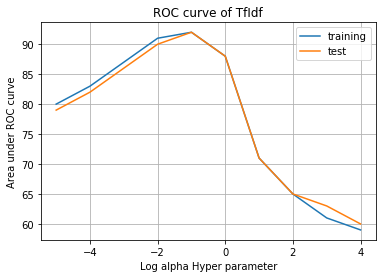

In [41]:
#printing all Auc value of corresponding k on validation and test data
df = pd.DataFrame({
                  'training': auc_cv,
                  'test': auc_test
                  }, index= log_alpha )

lines = df.plot.line()
plt.xlabel("Log alpha Hyper parameter")
plt.ylabel("Area under ROC curve")
plt.title("ROC curve of TfIdf")
plt.grid()
plt.show()

In [42]:
tfidf_clf = MultinomialNB(alpha = tfidf_optimal_alpha)
tfidf_clf.fit(tfidf_x_train, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

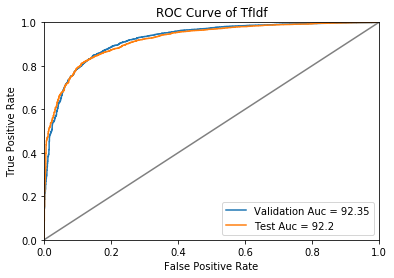

In [43]:
#auc curve of optimal k on validation and test data
y_predk_proba = tfidf_clf.predict_proba(tfidf_x_cv)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_cv,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_cv, y_predk_proba)*100, 2)
tfidf_tr_auc = auc

plt.plot(fpr,tpr,label="Validation Auc = "+str(auc))
y_predk_proba = tfidf_clf.predict_proba(tfidf_x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_test, y_predk_proba)*100, 2)
tfidf_ts_auc = auc

plt.plot(fpr,tpr,label="Test Auc = "+str(auc))
plt.legend(loc=4)
plt.plot([x/10 for x in range(0, 11)],[x/10 for x in range(0, 11)], color='grey')
plt.title("ROC Curve of TfIdf")
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [44]:
tfidf_pred_test = tfidf_clf.predict(tfidf_x_test)

In [45]:
tfidf_pred_cv = tfidf_clf.predict(tfidf_x_cv)

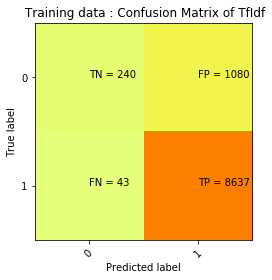

In [46]:
# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_cv,tfidf_pred_cv)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title(' Training data : Confusion Matrix of TfIdf')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

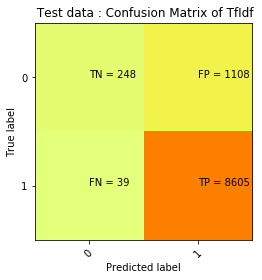

In [47]:
# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_test,tfidf_pred_test)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title(' Test data : Confusion Matrix of TfIdf')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [48]:
# Please write all the code with proper documentation

In [49]:
features_prob = tfidf_clf.feature_log_prob_

In [50]:
len(tfidf_vect.get_feature_names())

52873

In [51]:
pos_df = pd.DataFrame({'log prob': features_prob[1,:],
                   'word': tfidf_vect.get_feature_names()[:]
                  })
pos_largest_10= pos_df.nlargest(10, 'log prob')


In [52]:
from prettytable import PrettyTable
    
x = PrettyTable()
print("Top Ten features of TF_IDF belonging to class positive or 1")
x.field_names = ["Top ten fetures", "Features Log Probability", "Word"]
for i in range(0, 10):
    x.add_row([i+1, pos_largest_10["log prob"].values[i] ,\
               pos_largest_10["word"].values[i]])

print(x)

Top Ten features of TF_IDF belonging to class positive or 1
+-----------------+--------------------------+---------+
| Top ten fetures | Features Log Probability |   Word  |
+-----------------+--------------------------+---------+
|        1        |    -4.872003940559279    |   not   |
|        2        |    -5.148234102034973    |  great  |
|        3        |    -5.223641125190297    |   tea   |
|        4        |    -5.236337924591162    |   good  |
|        5        |    -5.336342758678936    |   like  |
|        6        |    -5.462916795232031    |   love  |
|        7        |    -5.509654641932935    | product |
|        8        |    -5.533340993209895    |  taste  |
|        9        |    -5.572257546130057    |  coffee |
|        10       |    -5.589607476620622    |  flavor |
+-----------------+--------------------------+---------+


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [53]:
# Please write all the code with proper documentation

In [54]:
neg_df = pd.DataFrame({'log prob': features_prob[0,:],
                   'word': tfidf_vect.get_feature_names()[:]
                  })
neg_largest_10= neg_df.nlargest(10, 'log prob')

In [55]:
from prettytable import PrettyTable
    
x = PrettyTable()
print("Top Ten Features of TF_IDF belonging to class negative or 0")
x.field_names = ["Top Ten Features", "Features Log Probability", "Word"]
for i in range(0, 10):
    x.add_row([i+1, neg_largest_10["log prob"].values[i] ,\
               neg_largest_10["word"].values[i]])

print(x)

Top Ten Features of TF_IDF belonging to class negative or 0
+------------------+--------------------------+---------+
| Top Ten Features | Features Log Probability |   Word  |
+------------------+--------------------------+---------+
|        1         |    -4.387290606943074    |   not   |
|        2         |    -5.19202724901321     |   like  |
|        3         |    -5.288455442236773    |  taste  |
|        4         |    -5.308075478134475    | product |
|        5         |    -5.312362140936821    |  would  |
|        6         |    -5.585137044436455    |   one   |
|        7         |    -5.754470988418995    |  flavor |
|        8         |    -5.776004796209273    |    no   |
|        9         |    -5.797645788420958    |  coffee |
|        10        |    -5.803048479614425    |   good  |
+------------------+--------------------------+---------+


# Adding length of review as another feature in Text for BOW

In [56]:
a = bow_x_train
b = bow_x_cv
c = bow_x_test

In [57]:
from scipy.sparse import coo_matrix, hstack
bow_x_train = hstack((bow_x_train, xtr_len_rvw))
bow_x_cv = hstack((bow_x_cv, xcv_len_rvw))
bow_x_test = hstack((bow_x_test, xts_len_rvw))

In [58]:
auc_cv = []
auc_test = []
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for i in tqdm(alpha):
    
    # instantiate learning model (k = 30)
    bow_clf = MultinomialNB(alpha = i)
    # fitting the model on crossvalidation train
    bow_clf.fit(bow_x_train, y_train)
    
    y_pred_proba = bow_clf.predict_proba(bow_x_cv)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_cv,  y_pred_proba)
    auc_cv.append(np.round(metrics.roc_auc_score(y_cv, y_pred_proba)*100))
    
    y_pred_proba1 = bow_clf.predict_proba(bow_x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba1)
    auc_test.append(np.round(metrics.roc_auc_score(y_test, y_pred_proba1)*100))
    

100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.44it/s]


In [59]:
bowL_optimal_alpha = alpha[(auc_cv.index(max(auc_cv)))]

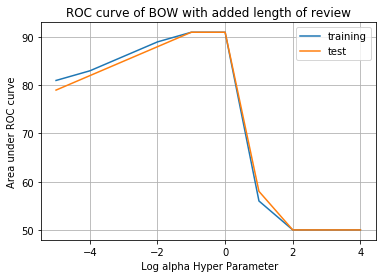

In [60]:
#printing all Auc value of corresponding k on validation and test data
df = pd.DataFrame({
                  'training': auc_cv,
                  'test': auc_test
                  }, index= log_alpha )

lines = df.plot.line()
plt.xlabel(" Log alpha Hyper Parameter")
plt.ylabel("Area under ROC curve")
plt.title("ROC curve of BOW with added length of review")
plt.grid()
plt.show()

In [61]:
bow_clf = MultinomialNB(alpha = bowL_optimal_alpha)
bow_clf.fit(bow_x_train, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

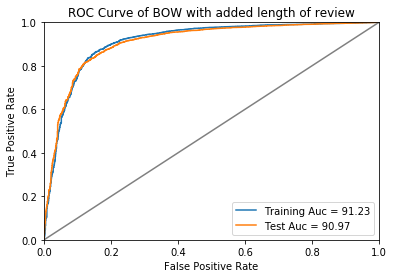

In [62]:
#auc curve of optimal k on validation and test data
y_predk_proba = bow_clf.predict_proba(bow_x_cv)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_cv,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_cv, y_predk_proba)*100, 2)
bowL_tr_auc = auc

plt.plot(fpr,tpr,label="Training Auc = "+str(auc))
y_predk_proba = bow_clf.predict_proba(bow_x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_test, y_predk_proba)*100, 2)
bowL_ts_auc = auc

plt.plot(fpr,tpr,label="Test Auc = "+str(auc))
plt.legend(loc=4)
plt.plot([x/10 for x in range(0, 11)],[x/10 for x in range(0, 11)], color='grey')
plt.title("ROC Curve of BOW with added length of review")
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [63]:
y_pred_test = bow_clf.predict(bow_x_test)

In [64]:
y_pred_cv = bow_clf.predict(bow_x_cv)

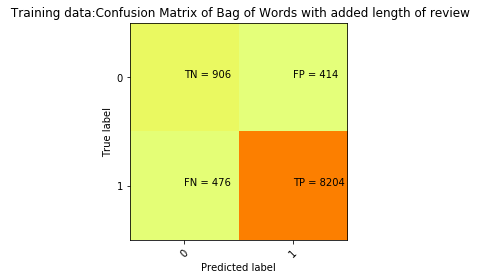

In [65]:
# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_cv,y_pred_cv)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title(' Training data:Confusion Matrix of Bag of Words with added length of review')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

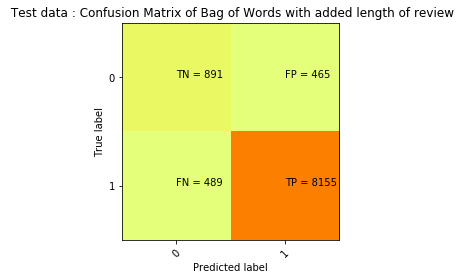

In [66]:
# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_test,y_pred_test)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title(' Test data : Confusion Matrix of Bag of Words with added length of review')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

# Adding length of review as another feature in Text for TFIDF

In [67]:
d = tfidf_x_train
e = tfidf_x_cv
f = tfidf_x_test

In [68]:
tfidf_x_train = hstack((tfidf_x_train, xtr_len_rvw))
tfidf_x_cv = hstack((tfidf_x_cv, xcv_len_rvw))
tfidf_x_test = hstack((tfidf_x_test, xts_len_rvw))

In [69]:
auc_cv = []
auc_test = []
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for i in tqdm(alpha):
    
    # instantiate learning model (k = 30)
    tfidf_clf = MultinomialNB(alpha = i)
    # fitting the model on crossvalidation train
    tfidf_clf.fit(tfidf_x_train, y_train)
    
    y_pred_proba = tfidf_clf.predict_proba(tfidf_x_cv)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_cv,  y_pred_proba)
    auc_cv.append(np.round(metrics.roc_auc_score(y_cv, y_pred_proba)*100))
    
    y_pred_proba1 = tfidf_clf.predict_proba(tfidf_x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba1)
    auc_test.append(np.round(metrics.roc_auc_score(y_test, y_pred_proba1)*100))
    

100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.42it/s]


In [70]:
tfidfL_optimal_alpha = alpha[(auc_cv.index(max(auc_cv)))]

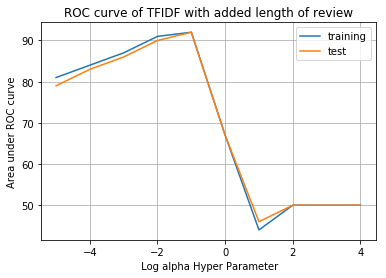

In [71]:
#printing all Auc value of corresponding k on validation and test data
df = pd.DataFrame({
                  'training': auc_cv,
                  'test': auc_test
                  }, index= log_alpha )

lines = df.plot.line()
plt.xlabel(" Log alpha Hyper Parameter")
plt.ylabel("Area under ROC curve")
plt.title("ROC curve of TFIDF with added length of review")
plt.grid()
plt.show()

In [72]:
tfidf_clf = MultinomialNB(alpha = tfidfL_optimal_alpha)
tfidf_clf.fit(bow_x_train, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

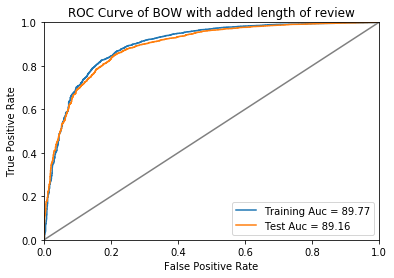

In [73]:
#auc curve of optimal k on validation and test data
y_predk_proba = bow_clf.predict_proba(tfidf_x_cv)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_cv,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_cv, y_predk_proba)*100, 2)
tfidfL_tr_auc = auc

plt.plot(fpr,tpr,label="Training Auc = "+str(auc))
y_predk_proba = bow_clf.predict_proba(tfidf_x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_test, y_predk_proba)*100, 2)
tfidfL_ts_auc = auc

plt.plot(fpr,tpr,label="Test Auc = "+str(auc))
plt.legend(loc=4)
plt.plot([x/10 for x in range(0, 11)],[x/10 for x in range(0, 11)], color='grey')
plt.title("ROC Curve of BOW with added length of review")
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [74]:
tfidf_pred_test = tfidf_clf.predict(tfidf_x_test)

In [75]:
tfidf_pred_cv = tfidf_clf.predict(tfidf_x_cv)

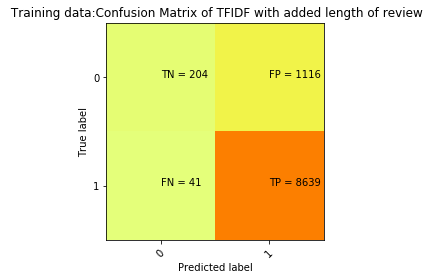

In [76]:
# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_cv,tfidf_pred_cv)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title(' Training data:Confusion Matrix of TFIDF with added length of review')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

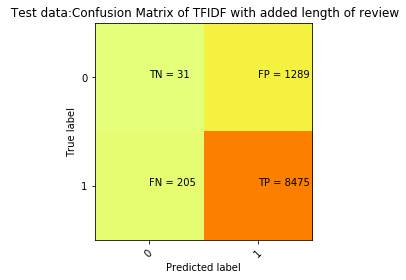

In [77]:
# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_cv, tfidf_pred_test)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title(' Test data:Confusion Matrix of TFIDF with added length of review')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

# Adding Some fearure of Summary in Text for BOW

In [78]:
# Combining all the above stundents
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|█████████████████████████████████| 100000/100000 [02:14<00:00, 745.83it/s]


In [79]:
#splitting data into train and test
xs_train = preprocessed_summary[slice(0,80000)]
xs_cv = preprocessed_summary[slice(80000, 90000)]
xs_test = preprocessed_summary[slice(90000, 100000)]
ys_train = final.iloc[:80000, 6]
ys_cv = final.iloc[80000:90000, 6]
ys_test = final.iloc[90000:100000, 6]



In [80]:
# Please write all the code with proper documentation
#defining function for Bag of words
def bow_s(para, bow_x_cv, bow_x_test):  
    count_vect_s = CountVectorizer(max_features = 10) #in scikit-learn
    bow_xs_train = count_vect_s.fit_transform(para)
    bow_xs_cv = count_vect_s.transform(x_cv)
    bow_xs_test = count_vect_s.transform(x_test)
    return bow_xs_train, bow_xs_cv, bow_xs_test , count_vect_s


In [81]:
#vectorizing using above function
bow_xs_train, bow_xs_cv, bow_xs_test, bow_vect_s= bow_s(xs_train, xs_cv, xs_test)

In [82]:
print("Printing top ten fetures from summary in descending order")
bow_vect_s.get_feature_names()

Printing top ten fetures from summary in descending order


['best',
 'coffee',
 'delicious',
 'excellent',
 'good',
 'great',
 'love',
 'not',
 'product',
 'tea']

In [83]:
bow_x_train = hstack((a, (bow_xs_train)))
bow_x_cv = hstack((b, (bow_xs_cv)))
bow_x_test = hstack((c, (bow_xs_test)))

In [84]:
auc_cv = []
auc_test = []
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for i in tqdm(alpha):
    
    # instantiate learning model (k = 30)
    bow_clf = MultinomialNB(alpha = i)
    # fitting the model on crossvalidation train
    bow_clf.fit(bow_x_train, ys_train)
    
    y_pred_proba = bow_clf.predict_proba(bow_x_cv)[::,1]
    fpr, tpr, _ = metrics.roc_curve(ys_cv,  y_pred_proba)
    auc_cv.append(np.round(metrics.roc_auc_score(ys_cv, y_pred_proba)*100))
    
    y_pred_proba1 = bow_clf.predict_proba(bow_x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(ys_test,  y_pred_proba1)
    auc_test.append(np.round(metrics.roc_auc_score(ys_test, y_pred_proba1)*100))
    

100%|██████████████████████████████████████████| 10/10 [00:06<00:00,  1.46it/s]


In [85]:
bowS_optimal_alpha = alpha[(auc_cv.index(max(auc_cv)))]

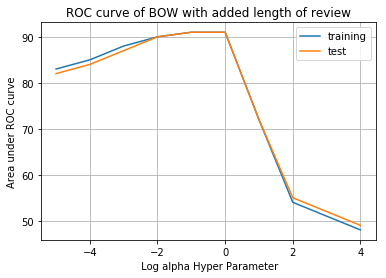

In [86]:
#printing all Auc value of corresponding k on validation and test data
df = pd.DataFrame({
                  'training': auc_cv,
                  'test': auc_test
                  }, index= log_alpha )

lines = df.plot.line()
plt.xlabel(" Log alpha Hyper Parameter")
plt.ylabel("Area under ROC curve")
plt.title("ROC curve of BOW with added length of review")
plt.grid()
plt.show()

In [87]:
bow_clf = MultinomialNB(alpha = bowS_optimal_alpha)
bow_clf.fit(bow_x_train, ys_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

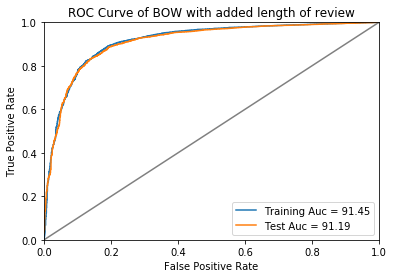

In [88]:
#auc curve of optimal k on validation and test data
y_predk_proba = bow_clf.predict_proba(bow_x_cv)[::,1]
fpr, tpr, _ = metrics.roc_curve(ys_cv,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(ys_cv, y_predk_proba)*100, 2)
bowS_tr_auc = auc

plt.plot(fpr,tpr,label="Training Auc = "+str(auc))
y_predk_proba = bow_clf.predict_proba(bow_x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(ys_test,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(ys_test, y_predk_proba)*100, 2)
bowS_ts_auc = auc

plt.plot(fpr,tpr,label="Test Auc = "+str(auc))
plt.legend(loc=4)
plt.plot([x/10 for x in range(0, 11)],[x/10 for x in range(0, 11)], color='grey')
plt.title("ROC Curve of BOW with added length of review")
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [89]:
bow_pred_test = bow_clf.predict(bow_x_test)

In [90]:
bow_pred_cv = bow_clf.predict(bow_x_cv)

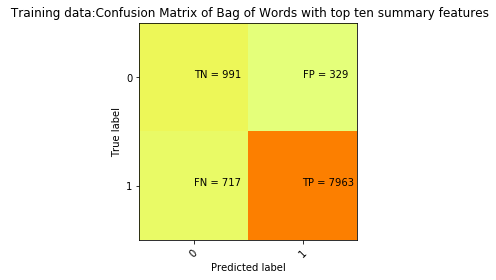

In [91]:
# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(ys_cv,bow_pred_cv)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title(' Training data:Confusion Matrix of Bag of Words with top ten summary features')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

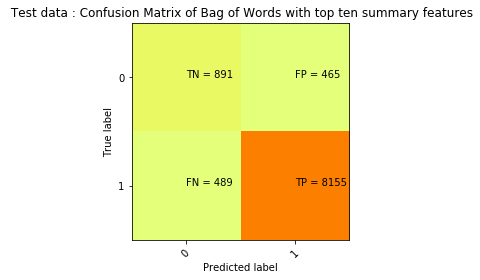

In [92]:
# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(ys_test,y_pred_test)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title(' Test data : Confusion Matrix of Bag of Words with top ten summary features')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

# Adding Some fearure of Summary in Text for TFIDF

In [93]:
def tfidf_s(preprocessed_reviews, x_cv, x_test):
    tfidf_vect = TfidfVectorizer(max_features = 10)
    tfidf_xs_train = tfidf_vect.fit_transform(preprocessed_reviews)
    tfidf_xs_cv = tfidf_vect.transform(x_cv)
    tfidf_xs_test = tfidf_vect.transform(x_test)
    return tfidf_xs_train, tfidf_xs_cv, tfidf_xs_test, tfidf_vect

In [94]:
len(xs_train)

80000

In [95]:
#vectorizing using above function
tfidf_xs_train, tfidf_xs_cv, tfidf_xs_test, tfidf_vect_s = \
                     tfidf_s(xs_train, xs_cv, xs_test)

In [96]:
print("Printing top ten fetures from summary in descending order")
print(tfidf_vect_s.get_feature_names())
print(bow_vect_s.get_feature_names())

Printing top ten fetures from summary in descending order
['best', 'coffee', 'delicious', 'excellent', 'good', 'great', 'love', 'not', 'product', 'tea']
['best', 'coffee', 'delicious', 'excellent', 'good', 'great', 'love', 'not', 'product', 'tea']


In [97]:
tfidf_xs_train

<80000x10 sparse matrix of type '<class 'numpy.float64'>'
	with 45207 stored elements in Compressed Sparse Row format>

In [98]:
tfidf_x_train = hstack((d, tfidf_xs_train))
tfidf_x_cv = hstack((e, tfidf_xs_cv))
tfidf_x_test = hstack((f, tfidf_xs_test))

In [99]:
auc_cv = []
auc_test = []
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for i in tqdm(alpha):
    
    # instantiate learning model (k = 30)
    tfidf_clf = MultinomialNB(alpha = i)
    # fitting the model on crossvalidation train
    tfidf_clf.fit(tfidf_x_train, ys_train)
    
    y_pred_proba = tfidf_clf.predict_proba(tfidf_x_cv)[::,1]
    fpr, tpr, _ = metrics.roc_curve(ys_cv,  y_pred_proba)
    auc_cv.append(np.round(metrics.roc_auc_score(ys_cv, y_pred_proba)*100))
    
    y_pred_proba1 = tfidf_clf.predict_proba(tfidf_x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(ys_test,  y_pred_proba1)
    auc_test.append(np.round(metrics.roc_auc_score(ys_test, y_pred_proba1)*100))
    

100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.42it/s]


In [100]:
tfidfS_optimal_alpha = alpha[(auc_cv.index(max(auc_cv)))]

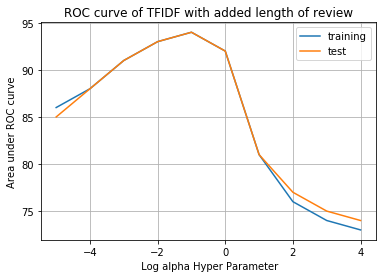

In [101]:
#printing all Auc value of corresponding k on validation and test data
df = pd.DataFrame({
                  'training': auc_cv,
                  'test': auc_test
                  }, index= log_alpha )

lines = df.plot.line()
plt.xlabel(" Log alpha Hyper Parameter")
plt.ylabel("Area under ROC curve")
plt.title("ROC curve of TFIDF with added length of review")
plt.grid()
plt.show()

In [102]:
tfidf_clf = MultinomialNB(alpha = tfidfS_optimal_alpha)
tfidf_clf.fit(bow_x_train, ys_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

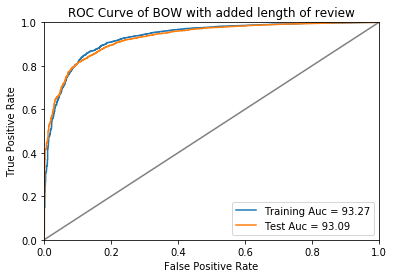

In [103]:
#auc curve of optimal k on validation and test data
y_predk_proba = bow_clf.predict_proba(tfidf_x_cv)[::,1]
fpr, tpr, _ = metrics.roc_curve(ys_cv,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(ys_cv, y_predk_proba)*100, 2)
tfidfS_tr_auc = auc

plt.plot(fpr,tpr,label="Training Auc = "+str(auc))
y_predk_proba = bow_clf.predict_proba(tfidf_x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(ys_test,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(ys_test, y_predk_proba)*100, 2)
tfidfS_ts_auc = auc

plt.plot(fpr,tpr,label="Test Auc = "+str(auc))
plt.legend(loc=4)
plt.plot([x/10 for x in range(0, 11)],[x/10 for x in range(0, 11)], color='grey')
plt.title("ROC Curve of BOW with added length of review")
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [104]:
tfidf_pred_test = tfidf_clf.predict(tfidf_x_test)

In [105]:
tfidf_pred_cv = tfidf_clf.predict(tfidf_x_cv)

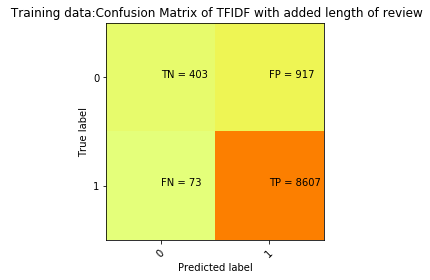

In [106]:
# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(ys_cv,tfidf_pred_cv)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title(' Training data:Confusion Matrix of TFIDF with added length of review')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

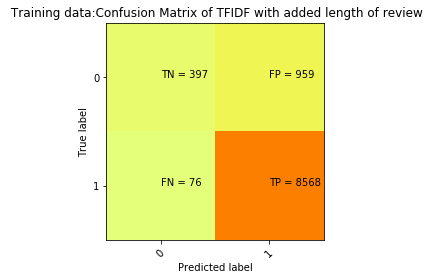

In [107]:
# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(ys_test,tfidf_pred_test)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title(' Training data:Confusion Matrix of TFIDF with added length of review')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

# [6] Conclusions

In [108]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model Technique", " alpha ", "Training Auc", "Test Auc"]
 
x.add_row(["Text BoW", bow_optimal_alpha, bow_tr_auc, bow_ts_auc ])
x.add_row(["Text TfIdf", tfidf_optimal_alpha, tfidf_tr_auc, tfidf_ts_auc ])
x.add_row(["Text BoW with len of review", bowL_optimal_alpha, bowL_tr_auc, bowL_ts_auc ])
x.add_row(["Text TfIdf with len of review", tfidfL_optimal_alpha, tfidfL_tr_auc, tfidfL_ts_auc ])
x.add_row(["Text BoW with Summary Bow", bowS_optimal_alpha, bowS_tr_auc, bowS_ts_auc ])
x.add_row(["Text Tfidf with Summary Tfidf", tfidfS_optimal_alpha, tfidfS_tr_auc, tfidfS_ts_auc ])
print(x)
print("Conclusion : As you can see above result that after feature engineering we are unable \
to get more accuracy or auc, getting almost equal accuracy.Even getting less accuracy with Feature engineering.")


+-------------------------------+---------+--------------+----------+
|        Model Technique        |  alpha  | Training Auc | Test Auc |
+-------------------------------+---------+--------------+----------+
|            Text BoW           |   0.1   |    91.23     |  90.97   |
|           Text TfIdf          |   0.1   |    92.35     |   92.2   |
|  Text BoW with len of review  |   0.1   |    91.23     |  90.97   |
| Text TfIdf with len of review |   0.1   |    89.77     |  89.16   |
|   Text BoW with Summary Bow   |   0.1   |    91.45     |  91.19   |
| Text Tfidf with Summary Tfidf |   0.1   |    93.27     |  93.09   |
+-------------------------------+---------+--------------+----------+
Conclusion : As you can see above result that after feature engineering we are unable to get more accuracy or auc, getting almost equal accuracy.Even getting less accuracy with Feature engineering.


# Step for all code:
    

In [ ]:
Preprocessing of the code:
    1. Importing all important library
    2. Loading data using sqlite3
    3. Making balanced data set
    4. Removing html, punctuation, from text and so on to fit into model
    5. dividing data into 3 part train test cv
Text BOW and TFIdf :    
    1. fitting train to bow model and transforming with train and cv and test
    2. taking  alpha value from 0.00001 to 10000 with increement  multiple of 10
    4. ploting all alpha with corresponding with auc so thatcan visualize optimal alpha
    3. finding alpha optimal 
    4. plotting roc curve of cv and test 
    5. plottinng confusion matrix of cv and test
Text Bow and Tfidf with length of text(Feature Engineering):
    1. Taking len of all review point and stacking with text bow and tfidf
    2. Taking  alpha value from 0.00001 to 10000 with increement  multiple of 10
    4. ploting all alpha with corresponding with auc so thatcan visualize optimal alpha
    3. finding alpha optimal 
    4. plotting roc curve of cv and test 
    5. plottinng confusion matrix of cv and test
Text Bow and Tfidf with top ten features of Summary(Feature Enginerring):
    1. Doing preprocessing of summary like removing html and xml form summary 
    2. Diving into three parts train test and cv
    3. Converting  into Bow and Tfidf
    4. Stacking  text bow with text summary and text tfidf with text sumary
    5. Taking  alpha value from 0.00001 to 10000 with increement  multiple of 10
    6. ploting all alpha with corresponding with auc so thatcan visualize optimal alpha
    7. finding alpha optimal 
    8. plotting roc curve of cv and test 
    9. plottinng confusion matrix of cv and test    